# Create UMAP of single cell features

In [1]:
from livecell_tracker.sample_data import tutorial_three_image

dic_dataset, mask_dataset = tutorial_three_image(dic_dataset_path="../datasets/test_data_STAV-A549/DIC_data", mask_dataset_path="../datasets/test_data_STAV-A549/mask_data")

3 png img file paths loaded: 
3 tif img file paths loaded: 


In [2]:
from livecell_tracker.core.io_sc import prep_scs_from_mask_dataset
scs = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


In [3]:
from livecell_tracker.trajectory.feature_extractors import compute_haralick_features, compute_skimage_regionprops
from livecell_tracker.preprocess.utils import normalize_img_to_uint8
for sc in scs:
    features = compute_skimage_regionprops(sc, preprocess_img_func=normalize_img_to_uint8)

In [4]:
sc.get_feature_pd_series()

skimage_area                 17509.000000
skimage_area_bbox            27090.000000
skimage_area_convex          18134.000000
skimage_area_filled          17509.000000
skimage_axis_major_length      233.508044
                                 ...     
skimage_orientation             -1.172603
skimage_perimeter              576.866053
skimage_perimeter_crofton      552.069997
skimage_solidity                 0.965534
t                                1.000000
Length: 148, dtype: float64

In [5]:
def create_sc_table(scs, normalize_features=True):
    import pandas as pd
    import numpy as np
    df = pd.DataFrame([sc.get_feature_pd_series() for sc in scs])
    if normalize_features:
        for col in df.columns:
            df[col] = (df[col] - df[col].mean())
            col_std = df[col].std()
            if col_std != 0 and not np.isnan(col_std):
                df[col] /= col_std
    # df["sc_id"] = [sc.id for sc in scs]
    # df["t"] = [sc.timeframe for sc in scs]
    # df.set_index("sc_id", inplace=True)
    return df

sc_feature_table = create_sc_table(scs)
sc_feature_table[:2]

,skimage_area,skimage_area_bbox,skimage_area_convex,skimage_area_filled,skimage_axis_major_length,skimage_axis_minor_length,skimage_bbox-0,skimage_bbox-1,skimage_bbox-2,skimage_bbox-3,...,skimage_moments_weighted_normalized-2-3,skimage_moments_weighted_normalized-3-0,skimage_moments_weighted_normalized-3-1,skimage_moments_weighted_normalized-3-2,skimage_moments_weighted_normalized-3-3,skimage_orientation,skimage_perimeter,skimage_perimeter_crofton,skimage_solidity,t
0,1.325555,1.324968,1.324565,1.325555,1.285639,1.259271,0.0,0.0,1.305655,1.274558,...,-1.321793,-1.322613,-1.251255,1.320709,-1.000184,1.283702,1.316389,1.311884,-1.148174,1.154419
1,1.325555,1.324968,1.324565,1.325555,1.285639,1.259271,0.0,0.0,1.305655,1.274558,...,-1.321793,-1.322613,-1.251255,1.320709,-1.000184,1.283702,1.316389,1.311884,-1.148174,1.154419


## Normalize features

## Perform UMAP on features

In [6]:
import umap
reducer = umap.UMAP()

In [7]:
# check if any columns are all NaN
sc_feature_table = sc_feature_table.dropna(axis=1, how="all")

In [8]:
embedding = reducer.fit_transform(sc_feature_table)

In [9]:
embedding.shape

(42, 2)

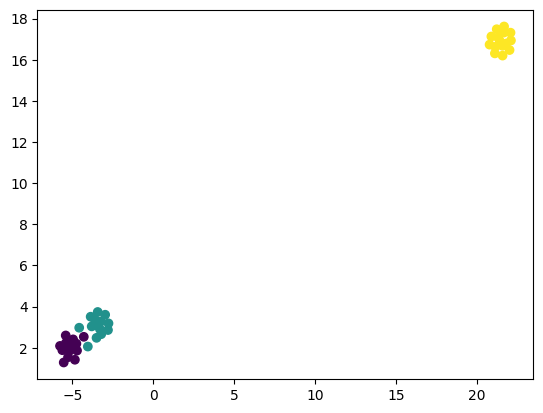

In [10]:
import matplotlib.pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sc.timeframe for sc in scs],
)

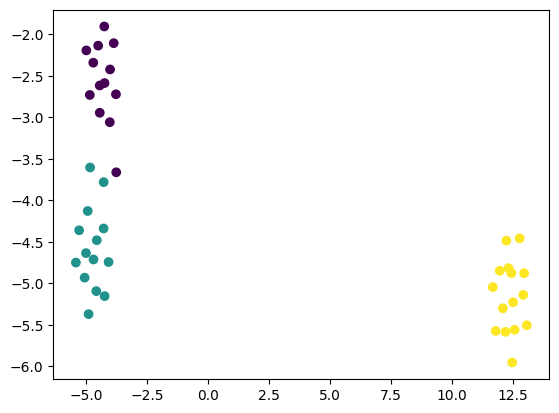

In [11]:
unnormalized_img_features = create_sc_table(scs, normalize_features=False)
# drop na
unnormalized_img_features = unnormalized_img_features.dropna(axis=1, how="all")
reducer = umap.UMAP()
unnormalized_embedding = reducer.fit_transform(unnormalized_img_features)
plt.scatter(
    unnormalized_embedding[:, 0],
    unnormalized_embedding[:, 1],
    c=[sc.timeframe for sc in scs],
)
